<a href="https://www.kaggle.com/code/bradhammond/cirrhosis-liver-rfc-xgb-neural-net?scriptVersionId=157960082" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Purpose

The purpose of this notebook is to give beginners an access point to learn how to stack models without using sklearn.

In [1]:
# import all of your libraries and datasets
import numpy as np
import pandas as pd 
from sklearn.preprocessing import RobustScaler, LabelEncoder
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout
import optuna


#import test and training datasets        
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv') 
train = train.drop('id', axis = 1)
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')

# This is the original dataset that I want to import to increase the size of my training set
# I added [train.columns] to make sure I only grabbed the matching columns from the original data
original_data = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv')[train.columns] 
train = pd.concat(objs=[train, original_data]).reset_index(drop=True)
# There are no missing values in the playground-series datasets but there are missing values in the orginal data, so we handle those by dropping them. 
train = train.dropna()

# since we will need the index later for submission we will save it now in a variable and drop it from the dataset
index = test['id']
test = test.drop('id', axis =1)


In [2]:
# Here we take a peak at our data to confirm changes
train.head()

,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [3]:
# Function to modify engineer my data
def transform_data(data):
    col_drop = []
# create a dictionary for the normal ranges of blood markers
    normal_ranges = {
    'Bilirubin': (0.1, 1.2),  # Normal range of bilirubin in mg/dL
    'Alk_Phos': (44, 147),    # Normal range of alkaline phosphatase in IU/L
    'SGOT': (10, 40),         # Normal range of SGOT in U/L
    'Albumin': (3.5, 5.0)     # Normal range of albumin in g/dL
    }

# normalize values for blood tests and then append them to col_drop so we can drop them later 
    for marker, (low, high) in normal_ranges.items():
        data[f'{marker}_normalized'] = (data[marker] - low) / (high - low)
        col_drop.append(f'{marker}_normalized')
        
# create a score that represents overall liver function 
    data['Liver_Function_Composite'] = data[['Bilirubin_normalized', 'Alk_Phos_normalized', 'SGOT_normalized', 'Albumin_normalized']].mean(axis=1)
# combine cholesteral and tryglicerides into a single feature, since both indicate dysfunction when they are high we will cross the two features
    data['Cholesterol_Tryglicerides_Ratio'] = data['Cholesterol'] * data['Tryglicerides']
# combine cholesteral and tryglicerides into a single feature, since both indicate dysfunction when they are low we will cross the two features
    data['Prothrombin_Platelets_Ratio'] = data['Prothrombin'] * data['Platelets'] 
# tranforming age into the age of diagnosis    
    data['Age'] = data['Age'] - data['N_Days']
# making cutoffs for meaningful scores for liver dysfunction to create a liver cirrohosis feature
    data['Ascites_score'] = data['Ascites'].map({'Y': 1, 'N': 0})  # Assuming 'Y' for Yes and 'N' for No
    data['Bilirubin_score'] = (data['Bilirubin'] > 1.2).astype(int)  # Elevated bilirubin
    data['Albumin_score'] = (data['Albumin'] < 3.5).astype(int)  # Low albumin
    data['Platelets_score'] = (data['Platelets'] < 150).astype(int)  # Low platelets
    data['Alk_Phos_score'] = (data['Alk_Phos'] > 147).astype(int)  # Elevated Alk_Phos
    data['SGOT_score'] = (data['SGOT'] > 40).astype(int)  # Elevated SGOT
    data['Prothrombin_score'] = (data['Prothrombin'] > 12).astype(int)  # Prolonged prothrombin time
    data['Spiders_score'] = data['Spiders'].map({'Y': 1, 'N': 0}) # Assuming 'Y' for Yes and 'N' for No
# Create a composite score for cirrhosis 
    data['Cirrhosis_Composite_Score'] = data[['Ascites_score', 'Bilirubin_score', 'Albumin_score', 'Platelets_score', 'Alk_Phos_score', 'SGOT_score', 'Prothrombin_score', 'Spiders_score']].sum(axis=1)
# Drop the columns that are repeats but keep Bilirubun Score as it is proved to be an important feature for determining outcomes in our models. 
    col_drop.extend(['Liver_Function_Composite','Cholesterol_Tryglicerides_Ratio','Prothrombin_Platelets_Ratio', 'Drug', 'Bilirubin', 'Ascites_score', 'Albumin_score', 'Platelets_score', 'Alk_Phos_score', 'SGOT_score', 'Prothrombin_score', 'Spiders_score'])
    data = data.drop(col_drop, axis = 1)    
    return data

train_df = transform_data(train)
test_df = transform_data(test)
# store feature names for use in graphs later
feature_names = [col for col in train_df.columns if col != 'Status']

In [4]:
# handle any nan values that arose because of the data transformation 
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

**Exploratory Data Analysis**

In this section we will explore aspects of the data to learn how we should attack making the model. We are looking for features that are correlated to our labels as well as any features that will need to be cleaned for missing values. 

When looking at the histograms distributions of the dataset (https://www.kaggle.com/competitions/playground-series-s3e26/data) I noticed that we will have to scale the data if we use any scale-dependent algorithms like a neural network. 

I also observed that there are some outliers in the different features, so those outliers may need to be removed to decrease the score of our log loss metric. 

Some features are catagorical and will need to be encoded. 

In [5]:
# get the basic statistics of the numerical columns of the training dataset
train.describe()

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,...,Prothrombin_Platelets_Ratio,Ascites_score,Bilirubin_score,Albumin_score,Platelets_score,Alk_Phos_score,SGOT_score,Prothrombin_score,Spiders_score,Cirrhosis_Composite_Score
count,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,...,8181.000000,8181.000000,8181.000000,8181.000000,8181.000000,8181.0,8181.000000,8181.000000,8181.000000,8181.000000
mean,2028.452512,16338.492483,2.619423,351.260237,3.547260,84.471825,1822.813348,114.925595,115.665322,265.112333,...,2807.116282,0.048772,0.446522,0.378316,0.089476,1.0,0.997433,0.044493,0.246791,3.251803
std,1094.820580,3952.038270,3.844169,196.856060,0.348327,76.403770,1911.409689,49.105416,53.034271,87.658802,...,930.567668,0.215403,0.497162,0.484997,0.285446,0.0,0.050603,0.206201,0.431171,1.255077
min,41.000000,5755.000000,0.300000,120.000000,1.960000,4.000000,289.000000,26.350000,33.000000,62.000000,...,620.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,1230.000000,13283.000000,0.700000,248.000000,3.350000,39.000000,834.000000,75.950000,84.000000,210.000000,...,2224.600000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,2.000000
50%,1831.000000,16301.000000,1.100000,299.000000,3.580000,63.000000,1181.000000,108.500000,104.000000,265.000000,...,2732.800000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,0.000000,3.000000
75%,2689.000000,18952.000000,3.000000,392.000000,3.770000,102.000000,1857.000000,137.950000,139.000000,316.000000,...,3307.700000,0.000000,1.000000,1.000000,0.000000,1.0,1.000000,0.000000,0.000000,4.000000
max,4795.000000,28451.000000,28.000000,1775.000000,4.640000,588.000000,13862.400000,457.250000,598.000000,563.000000,...,7319.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,8.000000


In [6]:
# Transform the catagorical features into numbers by using a label encoder
label_encoder = LabelEncoder()
for column in train_df.columns:
    if train_df[column].dtype in ['object', 'bool', 'category']:
        train_df[column] = label_encoder.fit_transform(train_df[column])
        if column in test.columns: #test doesn't have the 'status' column so we don't want to transform that column or our code will throw an error
            test_df[column] = label_encoder.transform(test_df[column])

        
# check to see if the dataframe has been encoded
train_df.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,Bilirubin_score,Cirrhosis_Composite_Score
0,999,20533,1,0,0,0,0,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2,1,4
1,2574,16663,0,0,0,0,0,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,0,2
2,3428,10299,0,0,1,1,2,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2,1,4
3,2576,15884,0,0,0,0,0,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,0,2
4,788,15870,0,0,1,0,0,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,0,2


In [7]:
# verify the test data has been transformed
test_df.head()

,N_Days,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Bilirubin_score,Cirrhosis_Composite_Score
0,3839,15885,0,0,1,0,0,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,0,3
1,2468,12507,0,0,0,0,0,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,0,2
2,51,13098,0,0,1,0,2,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,1,5
3,2330,18180,0,0,0,0,0,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,0,2
4,1615,20289,0,0,1,0,0,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,1,4


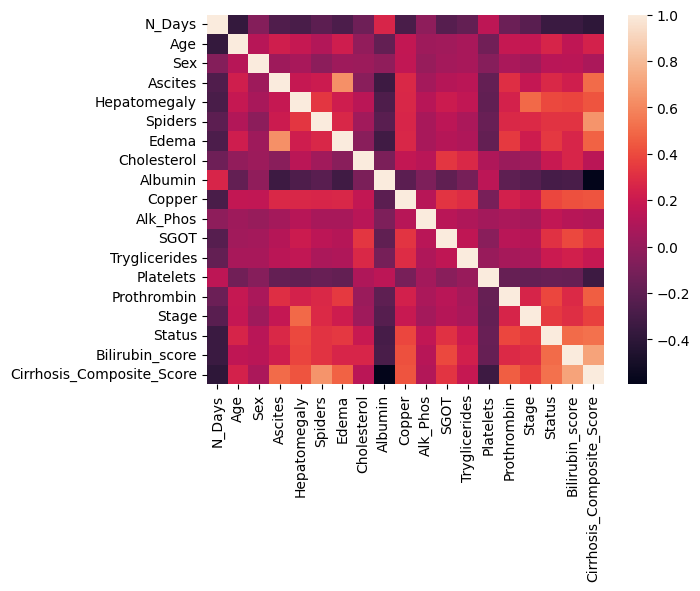

In [8]:
# I want to see what features are correlated so I can handle any covariance in the features 
corr_matrix = train_df.corr()
sn.heatmap(corr_matrix)
plt.show()

In [9]:
# I had a hard time differentiating between the colors, so I printed out
# the correlations so I could better understand the data. The last row of the 
# correlation matrix has our correlations between our status and every other
# feature.
print(corr_matrix.iloc[-1,:])

N_Days                      -0.395077
Age                          0.242873
Sex                          0.079457
Ascites                      0.506244
Hepatomegaly                 0.432259
Spiders                      0.646680
Edema                        0.474719
Cholesterol                  0.136436
Albumin                     -0.594024
Copper                       0.431440
Alk_Phos                     0.106073
SGOT                         0.327474
Tryglicerides                0.182996
Platelets                   -0.335154
Prothrombin                  0.459579
Stage                        0.367836
Status                       0.525009
Bilirubin_score              0.706323
Cirrhosis_Composite_Score    1.000000
Name: Cirrhosis_Composite_Score, dtype: float64


In [10]:
# scale the data for use in scale-dependent algorithms
y = train_df['Status']
X = train_df.drop(['Status'], axis=1)
scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test_real = scaler.transform(test_df)
# split the training data for validation and set a random state for repeatable results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=82)

# Build and Tune Random Forest Model
1. First we find the optimal hyperparameters using optuna
2. Then we build the model using the optimal hyperparameters.

In [11]:
# create function for optuna to call when optimizing
def objective(trial):
    # I tired optimizing other hyperparameters but estimators and leaf size were the most effective at minimizing log loss
    n_estimators = trial.suggest_int("n_estimators", 50, 200)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 50)

    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        random_state=82
    )

    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    logloss = log_loss(y_test, y_prob)
    return logloss

#create the study and run the optimization  
study = optuna.create_study(direction="minimize")  
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and score
best_params = study.best_params
best_score = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

[I 2024-01-06 20:31:49,452] A new study created in memory with name: no-name-bc59815c-6c9a-4438-bef4-606d3df52ed6
[I 2024-01-06 20:31:50,351] Trial 0 finished with value: 0.4657338587481569 and parameters: {'n_estimators': 99, 'min_samples_leaf': 24}. Best is trial 0 with value: 0.4657338587481569.
[I 2024-01-06 20:31:51,827] Trial 1 finished with value: 0.4681613466740412 and parameters: {'n_estimators': 169, 'min_samples_leaf': 26}. Best is trial 0 with value: 0.4657338587481569.
[I 2024-01-06 20:31:53,514] Trial 2 finished with value: 0.46230325548749607 and parameters: {'n_estimators': 182, 'min_samples_leaf': 19}. Best is trial 2 with value: 0.46230325548749607.
[I 2024-01-06 20:31:54,357] Trial 3 finished with value: 0.48120810525321916 and parameters: {'n_estimators': 109, 'min_samples_leaf': 50}. Best is trial 2 with value: 0.46230325548749607.
[I 2024-01-06 20:31:55,513] Trial 4 finished with value: 0.47424488402203285 and parameters: {'n_estimators': 141, 'min_samples_leaf': 

Best Hyperparameters: {'n_estimators': 152, 'min_samples_leaf': 2}
Best Score: 0.4404885068323723


In [12]:
# build model with best hyperparameters determined above
random_forest_model = RandomForestClassifier(n_estimators=171, min_samples_leaf=2, random_state=42)
random_forest_model.fit(X_train, y_train)
y_pred_forest_test = random_forest_model.predict_proba(X_test)
log_loss_metric = log_loss(y_test, y_pred_forest_test)
print(f'Log loss: {log_loss_metric}')

Log loss: 0.46192411879904466


In [13]:
# make predictions on test set using the RandomForestClassifier
y_pred_forest_real = random_forest_model.predict_proba(X_test_real)

# Build and Tune XBG Model
1. First we find the optimal hyperparameters using optuna
2. Then we build the model using the optimal hyperparameters.

In [14]:
def objective(trial):
#     hyperparametes adopted from https://www.kaggle.com/code/mostafamohammednouh/ps3e26-multi-class-prediction-of-cirrhosis
    params = {
        "objective": "multi_logloss",
        "n_estimators": trial.suggest_int('n_estimators', 500, 750),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0), 
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0), 
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    optuna_xgbmodel = xgb.XGBClassifier(**params,
                                    random_state=82)
    
    optuna_xgbmodel.fit(X_train, y_train)
    y_pred_probs = optuna_xgbmodel.predict_proba(X_test)
    logloss = log_loss(y_test, y_pred_probs)
    return logloss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_params)

[I 2024-01-06 20:33:04,923] A new study created in memory with name: no-name-7106e756-92f3-4095-b59f-8e685df6037a
[I 2024-01-06 20:33:06,771] Trial 0 finished with value: 0.5284926493011064 and parameters: {'n_estimators': 525, 'learning_rate': 0.0036874299685468515, 'max_depth': 5, 'subsample': 0.6285537609654623, 'colsample_bytree': 0.743488599929536, 'min_child_weight': 9}. Best is trial 0 with value: 0.5284926493011064.
[I 2024-01-06 20:33:08,513] Trial 1 finished with value: 0.4054877791102216 and parameters: {'n_estimators': 554, 'learning_rate': 0.03422576883939354, 'max_depth': 7, 'subsample': 0.8631118374373913, 'colsample_bytree': 0.2393201549223043, 'min_child_weight': 13}. Best is trial 1 with value: 0.4054877791102216.
[I 2024-01-06 20:33:10,107] Trial 2 finished with value: 0.42769328730761214 and parameters: {'n_estimators': 634, 'learning_rate': 0.01521189455532241, 'max_depth': 4, 'subsample': 0.9481274957142805, 'colsample_bytree': 0.8310124186982516, 'min_child_weigh

{'n_estimators': 737, 'learning_rate': 0.02092931458942847, 'max_depth': 7, 'subsample': 0.7998824772629701, 'colsample_bytree': 0.2776976739969433, 'min_child_weight': 12}


{'n_estimators': 666, 'learning_rate': 0.09792447281018261, 'max_depth': 3, 'subsample': 0.8802526465250708, 'colsample_bytree': 0.12328759472404174, 'min_child_weight': 9} with feature engineering

old params 
'objective': 'multi:softprob',  # Multi-class classification
    'eval_metric': 'mlogloss',     # Evaluation metric (log loss)
    'num_class': num_classes,      # Number of classes
    'max_depth': 10,                # Maximum depth of trees
    'learning_rate': 0.03970804555039867,
    'n_estimators': 572,
    'subsample': 0.5048914610683402,
    'colsample_bytree': 0.1299678713013594,
    'min_child_weight': 14,
    'enable_categorical': True

In [15]:
# build and train a XGB model for later use in the meta-model 
num_classes = 3 

params = {
    'objective': 'multi:softprob',  
    'eval_metric': 'mlogloss',    
    'num_class': num_classes,     
    'max_depth': 9,                
    'learning_rate': 0.024248428725181667,
    'n_estimators': 585,
    'subsample': 0.5442773274538859,
    'colsample_bytree': 0.19925924024894584,
    'min_child_weight': 5,
    
}

xgb_model = xgb.XGBClassifier(**params, random_state=82)
xgb_model.fit(X_train, y_train)
predictions_xgb_test = xgb_model.predict_proba(X_test)
metric = log_loss(y_test, predictions_xgb_test)
print(f'Log_loss: {metric}')

Log_loss: 0.40509307557170243


params = {
    'objective': 'multi:softprob',  # Multi-class classification
    'eval_metric': 'mlogloss',     # Evaluation metric (log loss)
    'num_class': num_classes,      # Number of classes
    'max_depth': 3,                # Maximum depth of trees
    'learning_rate': 0.09792447281018261,
    'n_estimators': 572,
    'subsample': 0.8802526465250708,
    'colsample_bytree': 0.12328759472404174,
    'min_child_weight': 9,

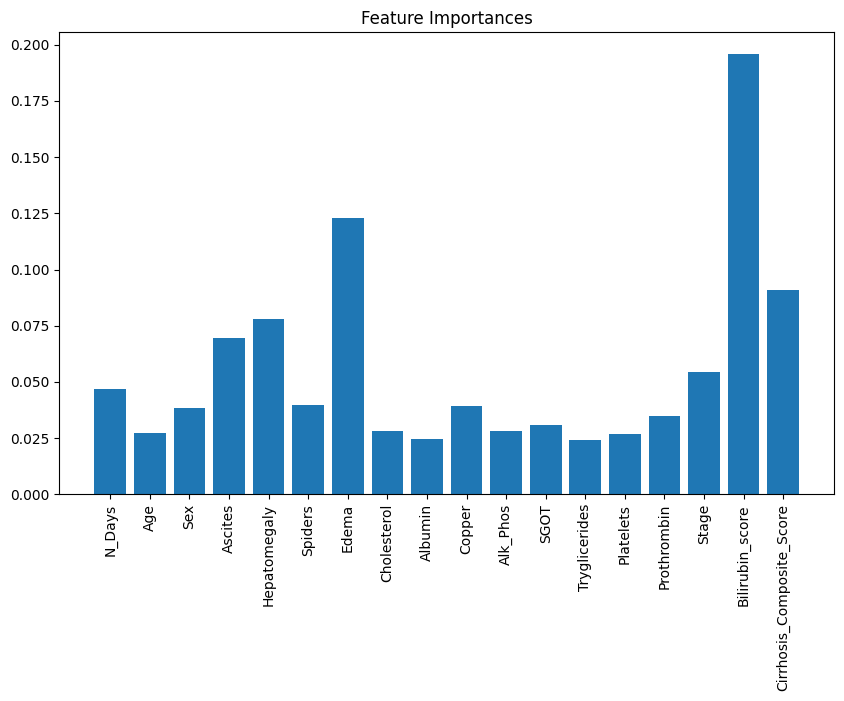

In [16]:
# I wanted to see what features are important to help guide my developement of my features. 
# I did use these importances to drop and add some features. The data transformtion function above
# is the final form after many iterations of checking feature importances in this model
importances = xgb_model.feature_importances_


# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.title('Feature Importances')
plt.show()

In [17]:
predictions_xgb_real = xgb_model.predict_proba(X_test_real)

{'n_estimators': 572, 'learning_rate': 0.03970804555039867, 'max_depth': 10, 'subsample': 0.5048914610683402, 'colsample_bytree': 0.1299678713013594, 'min_child_weight': 14}

# Build and Tune Neural Network
1. First we find the optimal hyperparameters using optuna
2. Then we build the model using the optimal hyperparameters.

In [18]:
# Define the objective function to optimize
def objective(trial):
    # Define hyperparameters to optimize
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    num_units = trial.suggest_int('num_units', 16, 256, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
#     num_hidden_layers = trial.suggest_int('num_hidden_layers', 1, 5)
    
    model = keras.Sequential()
    # Build and compile the neural network with the sampled hyperparameters
    model.add(Dense(num_units, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate)) 

#     I tried adding more layers to the model, but performance when down
#     for _ in range(num_hidden_layers):
#         model.add(Dense(num_units, activation='relu'))
#         model.add(Dropout(dropout_rate))  # Dropout layer for regularization

    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    y_train_onehot = to_categorical(y_train, num_classes=3)
    y_test_onehot = to_categorical(y_test, num_classes=3)
    history = model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_split=0.2, verbose=0, callbacks=[early_stopping])
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Create an Optuna study for hyperparameter optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_params = study.best_params
best_log_loss = study.best_value

print(f"Best Hyperparameters: {best_params}")
print(f"Best Log Loss: {best_log_loss:.4f}")



[I 2024-01-06 20:34:52,884] A new study created in memory with name: no-name-d1ed8399-489d-4930-81bc-7eb2d53e1e8d
[I 2024-01-06 20:34:56,162] Trial 0 finished with value: 0.4976576864719391 and parameters: {'learning_rate': 0.003382262419264585, 'num_units': 143, 'dropout_rate': 0.23468562708393415}. Best is trial 0 with value: 0.4976576864719391.
[I 2024-01-06 20:34:58,724] Trial 1 finished with value: 0.49739381670951843 and parameters: {'learning_rate': 0.002445094102287377, 'num_units': 221, 'dropout_rate': 0.2522156054683078}. Best is trial 1 with value: 0.49739381670951843.
[I 2024-01-06 20:35:10,158] Trial 2 finished with value: 0.49899330735206604 and parameters: {'learning_rate': 4.819225920257249e-05, 'num_units': 196, 'dropout_rate': 0.4006491253646439}. Best is trial 1 with value: 0.49739381670951843.
[I 2024-01-06 20:35:13,100] Trial 3 finished with value: 0.5191779136657715 and parameters: {'learning_rate': 0.008545280555926772, 'num_units': 181, 'dropout_rate': 0.3015410

Best Hyperparameters: {'learning_rate': 0.0011542118124277794, 'num_units': 91, 'dropout_rate': 0.40757873952366597}
Best Log Loss: 0.4890


In [19]:
# Define the neural network model
nn_model = keras.Sequential([
    keras.layers.Dense(165, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.048546988241455424),
    keras.layers.Dense(3, activation='softmax')  # Three classes, softmax activation for multi-class
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# log loss = categorical_crossentropy
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005326036230747182), loss='categorical_crossentropy', metrics=['accuracy'])

y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)
nn_model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])  # Adjust epochs and batch size


# Evaluate the model on test data with log loss
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test_onehot)
print(f"Test Log Loss: {test_loss:.4f}")

predictions_nn_test = nn_model.predict(X_test)

predictions_nn = nn_model.predict(X_test_real)
print(predictions_nn)

Epoch 1/50
164/164 [==============================] - 1s 2ms/step - loss: 0.7240 - accuracy: 0.7179 - val_loss: 0.5377 - val_accuracy: 0.8006
Epoch 2/50
164/164 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.7926 - val_loss: 0.5124 - val_accuracy: 0.7983
Epoch 3/50
164/164 [==============================] - 0s 1ms/step - loss: 0.5348 - accuracy: 0.7954 - val_loss: 0.5038 - val_accuracy: 0.8006
Epoch 4/50
164/164 [==============================] - 0s 1ms/step - loss: 0.5248 - accuracy: 0.7977 - val_loss: 0.4990 - val_accuracy: 0.7983
Epoch 5/50
164/164 [==============================] - 0s 2ms/step - loss: 0.5185 - accuracy: 0.8010 - val_loss: 0.4970 - val_accuracy: 0.7983
Epoch 6/50
164/164 [==============================] - 0s 2ms/step - loss: 0.5125 - accuracy: 0.8027 - val_loss: 0.4947 - val_accuracy: 0.8037
Epoch 7/50
164/164 [==============================] - 0s 1ms/step - loss: 0.5091 - accuracy: 0.8019 - val_loss: 0.4938 - val_accuracy: 0.7983
Epoch 

# Stack Preds and Build Meta Model
Here we stack the preds from the other models with the orginal features. 

In [20]:
# Stacked predictions from each model with the orginal features
stacked_preds = np.hstack((X_test, y_pred_forest_test, predictions_xgb_test, predictions_nn_test))
stacked_preds_test = np.hstack((X_test_real, y_pred_forest_real, predictions_xgb_real, predictions_nn))

In [21]:
# use a simple log regression model as our meta learner
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000, random_state=82)
model.fit(stacked_preds, y_test)
y_pred = model.predict_proba(stacked_preds)
metric = log_loss(y_test, y_pred)
print(f'Log loss: {metric}')
y_pred_real = model.predict_proba(stacked_preds_test)

Log loss: 0.39447845880311794


In [22]:
# preparing the data for submission
df = pd.DataFrame(y_pred_real, columns=['Status_C', 'Status_CL', 'Status_D'], index=index)
file_path = 'submission.csv'
df.to_csv(file_path) 

*I was able to get better results on the test set with an XGB model alone, so I would not use this meta learner because the meta learner is likely overfitting.